# 11830 - Homework 3

## Overview

The data for this assignment is available here. Your primary dataset consists of posts from Reddit. Each post is annotated with the gender of the post’s author (op_gender) and the subreddit where the post was made (subreddit). The main text of the post is in the column post_text. The contents of the provided data include:

- `classify.py`: a classifier that predicts the author’s gender and the subreddit for a post (example run: `python classify.py --test_file dataset.csv`). Note that this file also uses the two provided pickle files.
- `dataset.csv`: your primary data.
- `background.csv`: additional Reddit posts that you may optionally use for training an obfuscation model. A larger version is available here.
- `female.txt`: a list of words commonly used by women.
- `male.txt`: a list of words commonly used by men.

The provided classifier achieves an accuracy of 64.95% at identifying the gender of the poster and an accuracy of 85.85% at identifying a post’s subreddit when tested over `dataset.csv`. Your goal in this assignment is to obfuscate the data in `dataset.csv` so that the provided classifier is unable to determine the gender of authors, while still being able to determine the subreddit of the post. Note that in this set-up, we treat the provided classifier as a blackbox adversary (please do not try to hack it). This assignment was largely inspired by the paper Obfuscating Gender in Social Media Writing (Knight & Reddy, 2016), which may be a useful reference. Scenerios where this obfuscation model might be useful could be social media users who want to preserve their privacy by hiding their gender from the adversary, without losing the meaning of their post. You could also imagine this is a dataset of health records or other sensitive information that needs to be anonymized before providing it to NLP researchers.

In [1]:
import re
import string

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm

np.random.seed(11830)

## Read the data

In [2]:
!ls data

background.csv                 new_dataset_spacy.csv
background_large.csv           new_dataset_spacy_improved.csv
classify.py                    new_df_removed.csv
dataset.csv                    new_small.csv
deps.words.bin                 obfs_small.csv
deps.words.bz2                 save_df.csv
female.txt                     save_df1.csv
gender_classifier.pickle       small_edited
male.txt                       small_edited.csv
new_dataset.csv                small_obfuscated.csv
new_dataset_background.csv     subreddit_classifier.pickle


In [97]:
female_words = pd.read_fwf('data/female.txt', header=None)[0].values
male_words = pd.read_fwf('data/male.txt', header=None)[0].values

In [87]:
female_words, male_words

(array(['!', 'husband', 'we', ..., 'stood', 'stuck', 'rx'], dtype=object),
 array(['wife', '.', 'good', ..., 'captive', 'powerful', 'concord'],
       dtype=object))

In [5]:
df = pd.read_csv('data/dataset.csv')

In [6]:
df

,Unnamed: 0,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible
0,1200978,MexicanSpaceProgram,M,1200978,It really comes down to the circumstances unde...,relationships,False
1,747542,urmyheartBeatStopR,M,747542,"S.Korea, Japan, & China have tons of boy bands...",funny,False
2,721771,MadHatter69,M,721771,Those eyes.,funny,False
3,727114,on_the_redpill,M,727114,you need shades (Its not my fault if you keep...,funny,False
4,737662,oranjeeleven,M,737662,Nope.,funny,False
...,...,...,...,...,...,...,...
1995,718538,EgregiousWeasel,W,718538,Ill bet youre fun at parties.,funny,False
1996,719932,OhMyMoogle,W,719932,Well they keep their clothes on... so theres t...,funny,False
1997,1211454,Birdy1072,W,1211454,> There is no reasoning with this sub. This su...,relationships,False
1998,719803,palpablescalpel,W,719803,Some people like to work outside. Many of the ...,funny,False


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='op_gender', ylabel='count'>

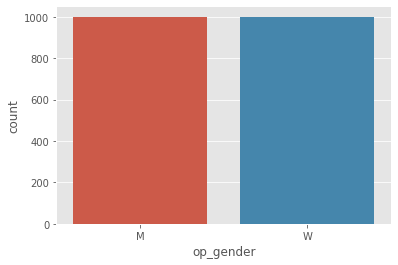

In [7]:
sns.countplot(df.op_gender)

## Basic requirements 

### First, build a baseline obfuscation model:
- For each post in dataset.csv, if the post was written by a man (M) and it contains words from `male.txt`, replace these words with a random word from `female.txt`.
- Obfuscate posts written by women (W) in the same way (i.e. by replacing words from `female.txt` with random words from `male.txt`)
- Test `classify.py` on your obfuscated data and analyze the results.

In [8]:
female_puncts = [i for i in female_words if i in string.punctuation]
male_puncts = [str(i) for i in male_words if str(i) in string.punctuation]

In [98]:
female_words = [x.lower() for x in female_words if x.isalpha()]
male_words = [x.lower() for x in male_words if isinstance(x, str) and x.isalpha()]

In [10]:
def get_random_female_word():
    i = np.random.randint(0, len(female_words))
    word = female_words[i]
#     while (not isinstance(word, str)) or any(x in string.punctuation for x in word):
#         i = np.random.randint(0, len(female_words))
#         word = female_words[i]
    return word

def get_random_male_word():
    i = np.random.randint(0, len(male_words))
    word = male_words[i]
#     while (not isinstance(word, str)) or any(x in string.punctuation for x in word):
#         i = np.random.randint(0, len(male_words))
#         word = male_words[i]
    return word

In [11]:
def get_female_punct():
    i = np.random.randint(0, len(female_puncts))
    return female_puncts[i]

def get_male_punct():
    i = np.random.randint(0, len(male_puncts))
    return male_puncts[i]

In [12]:
get_random_female_word() + get_female_punct()

'doctors-'

In [13]:
text = re.split('(\W+?)', "Nope.")
text = [token for token in text if token != '']
text

['Nope', '.']

In [15]:
def preprocess(sentence):
    if isinstance(sentence, float):
        return []
    else:
        sentence = sentence.lower()
        tokenized = re.findall(r'[^\W_]+', sentence)
        return tokenized

In [16]:
preprocess('nope.')

['nope']

In [325]:
altered_text = []

for i, row in df.iterrows():
    gender = row.op_gender # 'M' or 'F'
    text = row.post_text
#     text = re.split('(\W+?)', text)
    text = text.split(' ')
    text = [token.lower() for token in text if token != '']
    #text = preprocess(text)
    
    # if the post was written by a man (M) and it contains words from male.txt, 
    # replace these words with a random word from female.txt.
    final_sentence = []
    if gender == 'M':
        for token in text:
            if token in male_words:
                if token not in string.punctuation:
                    new_token = get_random_female_word()
                    final_sentence.append(new_token)
                else:
                    new_token = get_female_punct()
                    final_sentence.append(new_token)
            else:
                final_sentence.append(token)
                
    if gender == 'W':
        for token in text:
            if token in female_words:
                if token not in string.punctuation:
                    new_token = get_random_male_word()
                    final_sentence.append(new_token)
                else:
                    new_token= get_male_punct()
                    final_sentence.append(new_token)
            else:
                final_sentence.append(token)

    sentence = ' '.join([str(x) for x in final_sentence])
    altered_text.append(sentence)
    
    update = str(i) + ' / ' + str(len(df)) + ' --- ' + str(np.round(i * 100 / len(df), decimals=2)) + '%'
    print(update, end="\r")

In [326]:
with open("dataset_output.txt", "w") as txt_file:
    for line in altered_text:
        txt_file.write(line + "\n") # works with any number of elements in a line

In [327]:
df['altered_text'] = altered_text

In [328]:
new_df = df.copy()
new_df.drop('altered_text', inplace=True, axis=1)
new_df['post_text'] = altered_text
new_df.to_csv('data/new_dataset.csv')
new_df = pd.read_csv('data/new_dataset.csv')

In [329]:
count = 0
for i, row in df.iterrows():
    if len(row.post_text) > 100:
        pass
    elif count == 20:
        break
    else:
        if row.post_text.strip() != row.altered_text.strip():
            print(i)
            count += 1
            print("original:", row.post_text)
            print("altered:", row.altered_text)

2
original: Those eyes.
altered: those eyes.
3
original: you need shades  (Its not my fault if you keep your volume on maximum)
altered: drunkies stuffy shades (its colors my fault moscato dips stunning storyline doggy moody maximum)
4
original: Nope. 
altered: nope.
5
original: Well whenever he comes back into town you can sleep with him. Friends with benefits!
altered: toasty whenever he comes back miu manicurist garlic meds sleep with him. friends with benefits!
7
original: A Song of Ice and Fire is the greatest food and dress description novel series ever made.
altered: dried song snow ice and fire bff booking sample balloons and dress description drinks dandy ever made.
10
original: You do if you serve/sell liquor. In Canada, at least, everyone is ID-ed when buying liquor.
altered: dreams do caring childcare serve/sell liquor. punch canada, bronchitis least, everyone able id-ed when buying liquor.
13
original: Not a rocket exactly, retired equipment, unable to reach Mars... dammit

In [330]:
! cd data; python classify.py --test new_dataset.csv

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
1

### Second, improve your obfuscation model:
- Instead of replacing words from `male.txt` with randomly chosen words from `female.txt`, choose a semantically similar word from `female.txt` (use the same metric for replacing words from `female.txt` with words from `male.txt`). You may use any metric you choose for identifying semantically similar words. We recommend using cosine distance between pre-trained word embeddings (available here). You can also use SpaCy-based similarity here (example 1, example 2).
- Test `classify.py` on data obfuscated using your improved model and analyze the results. The classifier should perform close to random at identifying gender (e.g. <53.5%) and should obtain at least 79% accuracy on classifying the subreddit.

In [23]:
import spacy
  
nlp = spacy.load('en_core_web_lg')

In [54]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-200')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [64]:
glove_vectors.similarity('wife', 'mom')

0.68397903

In [136]:
glove_vectors.most_similar('desktop')

[('computer', 0.6576864719390869),
 ('interface', 0.6347222924232483),
 ('windows', 0.6202493906021118),
 ('wallpaper', 0.6058929562568665),
 ('pc', 0.5978425145149231),
 ('laptop', 0.5977668166160583),
 ('keyboard', 0.5974225401878357),
 ('mobile', 0.5922330021858215),
 ('gaming', 0.5874971747398376),
 ('ubuntu', 0.5835056304931641)]

In [24]:
# print("Enter two space-separated words")
# words = input()
# print(words)
  
# tokens = nlp(words)
  
# for token in tokens:
#     # Printing the following attributes of each token.
#     # text: the word string, has_vector: if it contains
#     # a vector representation in the model, 
#     # vector_norm: the algebraic norm of the vector,
#     # is_oov: if the word is out of vocabulary.
#     print(token.text, token.has_vector, token.vector_norm, token.is_oov)
  
# token1, token2 = tokens[0], tokens[1]
  
# print("Similarity:", token1.similarity(token2))

In [158]:
def find_closest_word(target_word, word_list):
    sim = []
    for word in word_list:
        #print(word, target_word)
#         if word in glove_vectors.key_to_index and target_word in glove_vectors.key_to_index:
#             #print(word in glove_vectors.key_to_index)
#             sim.append([word, glove_vectors.similarity(word, target_word)])
#         else:
        sim.append([word, target_word.similarity(word)])
    sim = sorted(sim, key=lambda x: x[1], reverse=True)
    closest_word = sim[0][0]
    return sim[0][0], sim[0][1]

In [159]:
'outforbloodi' in glove_vectors.key_to_index

False

In [160]:
female_tokens = [nlp(x) for x in tqdm(female_words)]
male_tokens = [nlp(str(x)) for x in tqdm(male_words)]

# female_tokens = female_words
# male_tokens = male_words

100%|██████████| 2842/2842 [00:16<00:00, 172.01it/s]


In [161]:
# female_tokens = list(set(female_tokens))
# male_tokens = list(set(male_tokens))

In [162]:
female_to_male = {}

for token in tqdm(female_tokens):
    closest_word, distance = find_closest_word(token, male_tokens)
    female_to_male[str(token)] = [str(closest_word), distance]

  0%|          | 0/2822 [00:00<?, ?it/s]<ipython-input-158-6e69ae86e88a>:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim.append([word, target_word.similarity(word)])
100%|██████████| 2822/2822 [01:45<00:00, 26.75it/s]


In [163]:
male_to_female = {}

for token in tqdm(male_tokens):
    closest_word, distance = find_closest_word(token, female_tokens)
    male_to_female[str(token)] = [str(closest_word), distance]

  0%|          | 0/2842 [00:00<?, ?it/s]<ipython-input-158-6e69ae86e88a>:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim.append([word, target_word.similarity(word)])
100%|██████████| 2842/2842 [01:48<00:00, 26.27it/s]


In [164]:
[x for x in female_words if x not in female_to_male]

[]

In [298]:
altered_text = []

for i, row in df.iterrows():
    gender = row.op_gender # 'M' or 'F'
    text = row.post_text
    # text = re.findall(r"[\w']+|[^\s\w]", text)
    # text = re.split('(\W+?)', text)
    text = text.split(' ')
    text = [token.lower() for token in text if token != '']
    #text = preprocess(text)
    
    # if the post was written by a man (M) and it contains words from male.txt, 
    # replace these words with a random word from female.txt.
    final_sentence = []
    if gender == 'M':
        for token in text:
            if token in male_words:
                if token not in male_to_female:
                    new_token = token
                else:
                    new_token = male_to_female[token][0]
                final_sentence.append(new_token)
            else:
                final_sentence.append(token)
                
    if gender == 'W':
        for token in text:
            if token in female_words:
                if token not in female_to_male:
                    new_token = token
                else:
                    new_token = female_to_male[token][0]
                final_sentence.append(new_token)
            else:
                final_sentence.append(token)

    sentence = ' '.join([str(x) for x in final_sentence])
    altered_text.append(sentence)
    
    update = str(i) + ' / ' + str(len(df)) + ' --- ' + str(np.round(i * 100 / len(df), decimals=2)) + '%'
    print(update, end="\r")

In [299]:
df['alt_text_spacy'] = altered_text

In [300]:
df

,Unnamed: 0,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible,altered_text,alt_text_spacy,alt_text_spacy_improved,alt_text_removed
0,1200978,MexicanSpaceProgram,M,1200978,It really comes down to the circumstances unde...,relationships,False,it really comes hung to remembers circumstance...,it really comes back to entire circumstances s...,it really comes back to the circumstances unde...,it really comes to circumstances which broke u...
1,747542,urmyheartBeatStopR,M,747542,"S.Korea, Japan, & China have tons of boy bands...",funny,False,caring korea sesame ugh have tons nudity boy b...,"s.korea, japan, & antique have tons and boy ba...","s.korea, japan, & china have tons of boy bands...","s.korea, japan, & have tons boy bands. i think..."
2,721771,MadHatter69,M,721771,Those eyes.,funny,False,those eyes,those eyes.,those eyes.,those eyes.
3,727114,on_the_redpill,M,727114,you need shades (Its not my fault if you keep...,funny,False,postino emails shades easter practically my fa...,sure needed shades (its would my fault sure su...,sure needed shades (its would my fault sure su...,shades (its my fault maximum)
4,737662,oranjeeleven,M,737662,Nope.,funny,False,nope,nope.,nope.,nope.
...,...,...,...,...,...,...,...,...,...,...,...
1995,718538,EgregiousWeasel,W,718538,Ill bet youre fun at parties.,funny,False,ill bet youre matched at constructiv,ill bet youre enjoyable at parties.,ill bet youre enjoyable at parties.,ill bet youre at parties.
1996,719932,OhMyMoogle,W,719932,Well they keep their clothes on... so theres t...,funny,False,well cleveland keep might screw on stakes ther...,well not keep themselves shirts on... quite th...,well not keep themselves clothes on... quite t...,well keep on... theres that.
1997,1211454,Birdy1072,W,1211454,> There is no reasoning with this sub. This su...,relationships,False,ernie is no reasoning with this sub this sub h...,> nothing is no reasoning with this sub. this ...,> nothing is no reasoning with this sub. this ...,> is no reasoning with this sub. this sub hate...
1998,719803,palpablescalpel,W,719803,Some people like to work outside. Many of the ...,funny,False,some people like sack work ketchup many of the...,some people like can work outside. many of the...,some people like can work outside. many of the...,some people like work outside. many of the mos...


In [301]:
# for i, row in df.iterrows():
#     if len(row.post_text) > 100:
#         pass
#     elif i == 15:
#         break
#     else:
#         print(i)
#         print("original:", row.post_text)
#         print("altered:", row.alt_text_spacy_improved)

In [302]:
new_df_spacy = df.copy()
new_df_spacy.drop('altered_text', inplace=True, axis=1)
new_df_spacy.drop('alt_text_spacy', inplace=True, axis=1)
new_df_spacy['post_text'] = df.alt_text_spacy.values
new_df_spacy.to_csv('data/new_dataset_spacy.csv')
new_df_spacy = pd.read_csv('data/new_dataset_spacy.csv')

In [303]:
! cd data; python classify.py --test new_dataset_spacy.csv

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
1

### Third, experiment with some basic modifications to your obfuscation models. 
For example, what if you randomly decide whether or not to replace words instead of replacing every lexicon word? What if you only replace words that have semantically similar enough counterparts?

In [261]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
stop_words = set(stopwords.words('english'))
remove = ['he', 'her', 'hers', 'herself', 'him', 'himself', 'his', 'she', "she's"]
for word in remove:
    stop_words.remove(word)
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'here',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 "shan't",
 'should',
 "should've",


In [43]:
male_pronouns = ['he', 'him', 'his', 'his', 'himself']
female_pronouns = ['she', 'her', 'her', 'hers', 'herself']

female_pronouns.index('she')

0

In [313]:
altered_text = []

for i, row in df.iterrows():
    gender = row.op_gender # 'M' or 'F'
    text = row.post_text
    # text = re.findall(r"[\w']+|[^\s\w]", text)
    # text = re.split('(\W+?)', text)
    text = text.split(' ')
    text = [token.lower() for token in text if token != '']
    # text = preprocess(text)
    
    # if the post was written by a man (M) and it contains words from male.txt, 
    # replace these words with a random word from female.txt.
    final_sentence = []
    if gender == 'M':
        for token in text:
#             if token in male_pronouns:
#                 new_token = (female_pronouns[male_pronouns.index(token)])
#                 final_sentence.append(new_token)
            if token in male_words:
                if token in male_to_female:
                    new_token, similarity = male_to_female[token]
                    if similarity < 0.7:
                        new_token = token
                else:
                    new_token = token
                final_sentence.append(new_token)
            else:
                final_sentence.append(token)
                
    if gender == 'W':
        for token in text:
#             if token in female_pronouns:
#                 new_token = (male_pronouns[female_pronouns.index(token)])
#                 final_sentence.append(new_token)
            if token in female_words:
                if token in female_to_male:
                    new_token, similarity = female_to_male[token]
                    if similarity < 0.7:
                        new_token = token
                else:
                    new_token = token
                final_sentence.append(new_token)
            else:
                final_sentence.append(token)

    sentence = ' '.join([str(x) for x in final_sentence])
    altered_text.append(sentence)
    
    update = str(i) + ' / ' + str(len(df)) + ' --- ' + str(np.round(i * 100 / len(df), decimals=2)) + '%'
    print(update, end="\r")

In [314]:
df['alt_text_spacy_improved'] = altered_text

In [335]:
count = 0
for i, row in df.iterrows():
    if len(row.post_text) > 100:
        pass
    elif count == 200:
        break
    else:
        if row.post_text.strip() != row.alt_text_spacy_improved.strip():
            print(i)
            count += 1
            print("original:", row.post_text)
            print("altered:", row.alt_text_spacy_improved)

2
original: Those eyes.
altered: those eyes.
3
original: you need shades  (Its not my fault if you keep your volume on maximum)
altered: sure needed shades (its would my fault sure sure sure our which before maximum)
4
original: Nope. 
altered: nope.
5
original: Well whenever he comes back into town you can sleep with him. Friends with benefits!
altered: but whenever he comes back back quaint sure able sleep with him. friends with benefits!
7
original: A Song of Ice and Fire is the greatest food and dress description novel series ever made.
altered: kind song and ice and fire which entire favorite eat and dress description books books ever made.
10
original: You do if you serve/sell liquor. In Canada, at least, everyone is ID-ed when buying liquor.
altered: sure do sure sure serve/sell liquor. outside canada, time least, everyone which id-ed when buying liquor.
13
original: Not a rocket exactly, retired equipment, unable to reach Mars... dammit OP, laughing hurts my soul.
altered: woul

In [292]:
new_df_spacy_improved = df.copy()
new_df_spacy_improved.drop('altered_text', inplace=True, axis=1)
new_df_spacy_improved.drop('alt_text_spacy', inplace=True, axis=1)
new_df_spacy_improved.drop('alt_text_spacy_improved', inplace=True, axis=1)

new_df_spacy_improved['post_text'] = altered_text
new_df_spacy_improved.to_csv('data/new_dataset_spacy_improved7.csv')
new_df_spacy_improved = pd.read_csv('data/new_dataset_spacy_improved7.csv')

In [293]:
! cd data; python classify.py --test new_dataset_spacy_improved7.csv

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
1

remove words completely

In [331]:
altered_text = []

for i, row in df.iterrows():
    gender = row.op_gender # 'M' or 'F'
    text = row.post_text
    # text = re.findall(r"[\w']+|[^\s\w]", text)
    # text = re.split('(\W+?)', text)
    text = text.split(' ')
    text = [token.lower() for token in text if token != '']
    
    # if the post was written by a man (M) and it contains words from male.txt, 
    # replace these words with a random word from female.txt.
    final_sentence = []
    if gender == 'M':
        for token in text:
            if token not in male_words:
                final_sentence.append(str(token))
        if len(final_sentence) == 0:
            final_sentence.append(get_random_female_word())
                
    if gender == 'W':
        for token in text:
            if token not in female_words:
                final_sentence.append(str(token))
        if len(final_sentence) == 0:
            final_sentence.append(get_random_male_word())

    sentence = ' '.join([str(x) for x in final_sentence])
    altered_text.append(sentence)
    
    update = str(i) + ' / ' + str(len(df)) + ' --- ' + str(np.round(i * 100 / len(df), decimals=2)) + '%'
    print(update, end="\r")

In [332]:
df['alt_text_removed'] = altered_text

In [334]:
count = 0
for i, row in df.iterrows():
    if len(row.post_text) > 100:
        pass
    elif count == 100:
        break
    else:
        if row.post_text.strip() != row.alt_text_removed.strip():
            print(i)
            count += 1
            print("original:", row.post_text)
            print("altered:", row.alt_text_removed)

2
original: Those eyes.
altered: those eyes.
3
original: you need shades  (Its not my fault if you keep your volume on maximum)
altered: shades (its my fault maximum)
4
original: Nope. 
altered: nope.
5
original: Well whenever he comes back into town you can sleep with him. Friends with benefits!
altered: whenever he comes back sleep with him. friends with benefits!
7
original: A Song of Ice and Fire is the greatest food and dress description novel series ever made.
altered: song ice and fire and dress description ever made.
10
original: You do if you serve/sell liquor. In Canada, at least, everyone is ID-ed when buying liquor.
altered: do serve/sell liquor. canada, least, everyone id-ed when buying liquor.
13
original: Not a rocket exactly, retired equipment, unable to reach Mars... dammit OP, laughing hurts my soul.
altered: rocket exactly, retired equipment, unable to reach mars... dammit op, laughing hurts my soul.
15
original: Have you handled anything besides $1 notes in the last

In [296]:
new_df_removed = df.copy()
new_df_removed.drop('altered_text', inplace=True, axis=1)
new_df_removed.drop('alt_text_spacy', inplace=True, axis=1)
new_df_removed.drop('alt_text_spacy_improved', inplace=True, axis=1)
new_df_removed.drop('alt_text_removed', inplace=True, axis=1)

new_df_removed['post_text'] = altered_text
new_df_removed.to_csv('data/new_df_removed.csv')
new_df_removed = pd.read_csv('data/new_df_removed.csv')

In [297]:
! cd data; python classify.py --test new_df_removed.csv

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
1

# Advanced Analysis

In [45]:
df_all = pd.read_csv('data/background.csv')

In [46]:
df_all.head(5), df_all.shape

(   Unnamed: 0         op_id op_gender  post_id  \
 0           0       Kastoli         M        0   
 1           1       Kastoli         M        1   
 2           2      DCBizzle         M        2   
 3           3        ordona         M        3   
 4           4  SlayerMaster         M        4   
 
                                            post_text  subreddit  \
 0                               slayer task perhaps?  2007scape   
 1       Black DHide legs, possibly an initiate pure?  2007scape   
 2                                  Whats a tonk? lol  2007scape   
 3  Do the Stronghold of Security for a free 10k t...  2007scape   
 4  I cant tell if this guy just doesnt speak Engl...  2007scape   
 
    op_gender_visible  
 0              False  
 1              False  
 2              False  
 3              False  
 4              False  ,
 (899999, 7))

In [47]:
# # Preprocess data
# ## Note: First create a dev.txt file such that
# ## 1. Each instance is on a new line
# ## 2. The label and the sentence are separated by a space
# python preprocess.py -train_src ../data/political_data/classtrain.txt -label0 democratic -label1 republican -valid_src ../data/political_data/dev.txt -save_data political -src_vocab_size 20000

# # Train the classifier
# python cnn_train.py -data political.train.pt -save_model political_model

# # Test the classifier accuracy
# python cnn_translate.py -model political_model_<best_model> -src ../data/political_data/democratic_only.test.en -tgt 'democratic' -label0 republican -label1 democratic


In [48]:
df_all.head()

,Unnamed: 0,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible
0,0,Kastoli,M,0,slayer task perhaps?,2007scape,False
1,1,Kastoli,M,1,"Black DHide legs, possibly an initiate pure?",2007scape,False
2,2,DCBizzle,M,2,Whats a tonk? lol,2007scape,False
3,3,ordona,M,3,Do the Stronghold of Security for a free 10k t...,2007scape,False
4,4,SlayerMaster,M,4,I cant tell if this guy just doesnt speak Engl...,2007scape,False


In [49]:
dataset = df_all[['op_gender', 'post_text', 'subreddit']]

In [50]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.3)
test, dev = train_test_split(test, test_size=0.5)

In [51]:
dev

,op_gender,post_text,subreddit
666920,M,Thats because you give all your money to Islam...,europe
232807,M,there was a thread he started a while back whe...,AskReddit
653958,M,My only issue with the set is that it doesnt h...,DotA2
291749,M,"No, please leave your shit in the toilet, stop...",AskReddit
539851,W,I am about to take delivery of two 6 week old ...,aww
...,...,...,...
79629,M,At least youre openly a dick,AskMen
180298,M,"Im happy if they do like me, naturally. But I ...",AskMen
777517,W,That is not an excuse.,gaming
432590,M,A 125 foot tall cow? Giraffes maybe?,AskReddit


In [52]:
train.to_csv('train.csv', header=True, sep='\t', index=False)
dev.to_csv('dev.csv', header=True, sep='\t', index=False)
test.to_csv('test.csv', header=True, sep='\t', index=False)

In [54]:
! cd data; python classify.py --test obfs_small.csv

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
1

In [58]:
obf_small = pd.read_csv('data/obfs_small.csv')

In [59]:
obf_small

,Unnamed: 0,op_gender,post_text,subreddit,original,target,text,obfuscated_text
0,0,M,It really comes down to the circumstances unde...,relationships,M,W,"['it', 'really', 'comes', 'down', 'to', 'the',...",it really comes down to the circumstances unde...
1,1,M,"S.Korea, Japan, & China have tons of boy bands...",funny,M,W,"['s', 'korea', 'japan', 'china', 'have', 'tons...",s thailand thailand australia have tons of boy...
2,2,M,Those eyes.,funny,M,W,"['those', 'eyes']",those eyes
3,3,M,you need shades (Its not my fault if you keep...,funny,M,W,"['you', 'need', 'shades', 'its', 'not', 'my', ...",you need shades its not my fault if you keep y...
4,4,M,Nope.,funny,M,W,['nope'],nope
...,...,...,...,...,...,...,...,...
1995,1995,W,Ill bet youre fun at parties.,funny,W,M,"['ill', 'bet', 'youre', 'fun', 'at', 'parties']",prolly bet youre party at parties
1996,1996,W,Well they keep their clothes on... so theres t...,funny,W,M,"['well', 'they', 'keep', 'their', 'clothes', '...",yea they keep their suits on so theres that
1997,1997,W,> There is no reasoning with this sub. This su...,relationships,W,M,"['there', 'is', 'no', 'reasoning', 'with', 'th...",there is no reasoning with this sub this sub g...
1998,1998,W,Some people like to work outside. Many of the ...,funny,W,M,"['some', 'people', 'like', 'to', 'work', 'outs...",some people like to work damn great of the mos...


In [60]:
new = pd.DataFrame()
new['op_gender'] = obf_small['op_gender']
new['post_text'] = obf_small['obfuscated_text']
new['subreddit'] = obf_small['subreddit']

In [61]:
new

,op_gender,post_text,subreddit
0,M,it really comes down to the circumstances unde...,relationships
1,M,s thailand thailand australia have tons of boy...,funny
2,M,those eyes,funny
3,M,you need shades its not my fault if you keep y...,funny
4,M,nope,funny
...,...,...,...
1995,W,prolly bet youre party at parties,funny
1996,W,yea they keep their suits on so theres that,funny
1997,W,there is no reasoning with this sub this sub g...,relationships
1998,W,some people like to work damn great of the mos...,funny


In [62]:
new.to_csv('data/new_small.csv')

In [63]:
! cd data; python classify.py --test new_small.csv

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
1

In [83]:
text = obf_small.text
obfs = obf_small.obfuscated_text.values

In [86]:
obf_small.text[0]

"['it', 'really', 'comes', 'down', 'to', 'the', 'circumstances', 'under', 'which', 'you', 'broke', 'up', 'and', 'your', 'relationship', 'if', 'any', 'afterwards', 'ive', 'had', 'exes', 'that', 'things', 'ended', 'relatively', 'well', 'with', 'or', 'at', 'least', 'after', 'some', 'time', 'had', 'passed', 'my', 'so', 'and', 'i', 'went', 'to', 'ones', 'wedding', 'a', 'couple', 'of', 'years', 'ago', 'have', 'been', 'dating', 'the', 'most', 'magnificent', 'and', 'beautiful', 'girl', 'i', 'could', 'have', 'ever', 'asked', 'for', 'so', 'youre', 'happy', 'now', 'who', 'gives', 'a', 'fuck', 'what', 'your', 'ex', 'is', 'doing', 'or', 'who', 'shes', 'doing', 'it', 'with', 'be', 'happy', 'with', 'what', 'youve', 'got', 'and', 'move', 'on', 'certainly', 'sounds', 'like', 'she', 'has', 'ex', 'has', 'been', 'dating', 'a', 'former', 'friend', 'co', 'worker', 'ive', 'never', 'understood', 'why', 'this', 'is', 'an', 'issue', 'for', 'people', 'jesus', 'its', 'your', 'ex', 'who', 'gives', 'a', 'shit', 'an

In [103]:
a = zip(text, obfs)
changed_indices = []
for i, (t, o) in enumerate(a):
    t = eval(t)
    t = ' '.join(t)
    if len(t) < 100 and t!=o:
        changed_indices.append(i)
        print(t)
        print(o)
        print(' ')

a song of ice and fire is the greatest food and dress description novel series ever made
a song of ice and way is the most food and dress description novel show ever made
 
you do if you serve sell liquor in canada at least everyone is id ed when buying liquor
you do if you serve bring liquor in canada at least everyone is id ed when getting liquor
 
not a rocket exactly retired equipment unable to reach mars dammit op laughing hurts my soul
not a rocket exactly retired facility unable to reach bruno wtf op laughing hurts my soul
 
have you handled anything besides 1 notes in the last decade
have you handled anything besides 1 notes in the first year
 
program jesus christ
course god god
 
itt people thinking they are cool because they dont like douglas adams
shitt people thinking they are cool because they dont like douglas douglas
 
y u no keep karma machine
y a no keep karma way
 
still do tho they seem to be a lil more current these days only a week or 2 until the get it now
still 

i totally agree with you this crazy rapture idea is very new but some hold to it
i totally agree with you this crazy rapture idea is very good but some hold to it
 
i still hear it every time that ring tone plays
i still hear it every time that ring tone makes
 
i truly dont fear many things but i despise life like dolls
i truly dont fear many things but i hate life like dolls
 
saw this on the news in the dentist today the headline was weiner under immense pressure
saw this on the news in the dentist today the news was weiner under immense pressure
 
3 billion wow
3 five wow
 
this would be funnier if the guy in the picture was a real canadian
this would be funnier if the guy in the picture was a real canada
 
first time i watched i didnt notice snoopy in the background
first time i watched i didnt notice snoopy in the thing
 
how did you survive those attacks
how did you survive those threats
 
pb j is always awesome period
pb jen is always awesome period
 
my pomeranian likes to sle

part of being a doctor is being able to comunicate people die if doctors cant dont do it
part of being a doctor is being able to comunicate people kill if lawyers cant dont do it
 
its a new motivational poster for teamwork
its a new motivational project for teamwork
 
bigamy is only morally wrong if all parties are not consenting
bigamy is only politically wrong if all parties are not consenting
 
i guess its better than sitting next to a dick
i guess its better than gonna last to a fuck
 
he owns a dog not a cat this dog needs some exercise
he owns a bull not a monster this bull needs some workout
 
truth conversely i would feel horribly uncomfortable leaving the house without a bra flop flop flop
truth conversely i would feel poorly uncomfortable leaving the house without a man flop flop flop
 
edit comment re posted elsewhere
upload image re uploaded elsewhere
 
this will be on facebook tomorrow they love shitposts
this will be on tweet tommorow they love shitposts
 
by evergreen c

cico and exercise works for all shapes sizes and ages
cico and workout works for all symbols sizes and ages
 
it puts the lotion on its skin or else it gets the hose again
it moves the moisturiser on its light or else it gives the hose again
 
how are you even supposed to respond to that uh you need a diagram
how are you damn supposed to respond to that shit you need a diagram
 
thats because youre fluent in english seeing how scat is an english word
thats because youre arabic in malay gonna how scat is an malay meaning
 
lucky for you ombre is in right now so technically you have really fashionable labia
great for you ombre is in right now so basically you have really chic labia
 
lol thats like four hours away ill see my brother some other time lol
shit thats like million seconds last anyways watch my bro some other time shit
 
that cant be gimli gimli carries a bow thats obviously han solo
that cant be aragorn aragorn carries a bow thats basically han solo
 
ill bet youre fun at par

In [105]:
len(changed_indices)

579

In [106]:
obf_small

,Unnamed: 0,op_gender,post_text,subreddit,original,target,text,obfuscated_text
0,0,M,It really comes down to the circumstances unde...,relationships,M,W,"['it', 'really', 'comes', 'down', 'to', 'the',...",it really comes down to the circumstances unde...
1,1,M,"S.Korea, Japan, & China have tons of boy bands...",funny,M,W,"['s', 'korea', 'japan', 'china', 'have', 'tons...",s thailand thailand australia have tons of boy...
2,2,M,Those eyes.,funny,M,W,"['those', 'eyes']",those eyes
3,3,M,you need shades (Its not my fault if you keep...,funny,M,W,"['you', 'need', 'shades', 'its', 'not', 'my', ...",you need shades its not my fault if you keep y...
4,4,M,Nope.,funny,M,W,['nope'],nope
...,...,...,...,...,...,...,...,...
1995,1995,W,Ill bet youre fun at parties.,funny,W,M,"['ill', 'bet', 'youre', 'fun', 'at', 'parties']",prolly bet youre party at parties
1996,1996,W,Well they keep their clothes on... so theres t...,funny,W,M,"['well', 'they', 'keep', 'their', 'clothes', '...",yea they keep their suits on so theres that
1997,1997,W,> There is no reasoning with this sub. This su...,relationships,W,M,"['there', 'is', 'no', 'reasoning', 'with', 'th...",there is no reasoning with this sub this sub g...
1998,1998,W,Some people like to work outside. Many of the ...,funny,W,M,"['some', 'people', 'like', 'to', 'work', 'outs...",some people like to work damn great of the mos...


In [111]:
import pickle
from nltk.tokenize import word_tokenize

cache_name = 'data/gender_classifier.pickle'

def get_preds(cache_name, test):
    m,v = pickle.load(open(cache_name, 'rb'))
    test = [" ".join(word_tokenize(t)) for t in tqdm(test)]
    test_data_features = v.transform(test)
    # print(test_data_features)
    preds = m.predict(test_data_features)
    return preds

gender_preds = get_preds(cache_name, obf_small.obfuscated_text.values)
reddit_preds = get_preds('data/subreddit_classifier.pickle', obf_small.obfuscated_text.values)


100%|██████████| 2000/2000 [00:01<00:00, 1924.85it/s]

100%|██████████| 2000/2000 [00:01<00:00, 1473.37it/s]


In [112]:
obf_small['gender_preds'] = gender_preds
obf_small['reddit_preds'] = reddit_preds

In [219]:
m_to_w = obf_small[obf_small.op_gender != obf_small.gender_preds][obf_small.op_gender == 'M'][['post_text', 'obfuscated_text']]
for i, row in m_to_w.iterrows():
    p = row.post_text
    o = row.obfuscated_text
    if len(p) < 300:
        print('original: ', p)
        print('changed:  ', o)
        print(' ')
    

original:  S.Korea, Japan, & China have tons of boy bands.  I think One Direction is a boy band.  So I dont they theyve disappeared? I think its much rare in term of popularity in English countries now and most of them are in Asia. 
changed:   s thailand thailand australia have tons of boy bands i think one love is a boy band so i dont they theyve disappeared i think its much rare in term of popularity in english people now and most of them are in australia
 
original:  you need shades  (Its not my fault if you keep your volume on maximum)
changed:   you need shades its not my fault if you keep your volume on maximum
 
original:  I guess he has the habit to pay for everything and she doesnt like it. I think most girls dont like it too
changed:   i guess he has the habit to pay for everything and she doesnt like it i think most girls dont like it too
 
original:  Even though she is not associated with the school, she still may face charges of using a position of authority to have sex wi

<ipython-input-219-b7f5cfce8aa6>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m_to_w = obf_small[obf_small.op_gender != obf_small.gender_preds][obf_small.op_gender == 'M'][['post_text', 'obfuscated_text']]


In [220]:
w_to_m = obf_small[obf_small.op_gender != obf_small.gender_preds][obf_small.op_gender == 'W'][['post_text', 'obfuscated_text']]
for i, row in w_to_m.iterrows():
    p = row.post_text
    o = row.obfuscated_text
    if len(p) < 300:
        print('original: ', p)
        print('changed:  ', o)
        print(' ')
    

<ipython-input-220-7a3835a3f22a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w_to_m = obf_small[obf_small.op_gender != obf_small.gender_preds][obf_small.op_gender == 'W'][['post_text', 'obfuscated_text']]


original:  Thats what I normally do but that toilet doesnt have a lid.
changed:   thats what i basically do but that lift doesnt have a lid
 
original:  I have no idea if youre going crazy, but I would say you are not overreacting. Why hasnt she spoken to you in a month? That sure sounds like a fade away style break up to me...
changed:   i have no idea if youre going fuckin but i would say you are not overreacting why hasnt she given to you in a season that sure sounds like a fade away style break up to me
 
original:  I laughed at that harder than I should and Im a girl 
changed:   i tweeted at that better than i should and ima a girl
 
original:  Youre just trying to be original and not say Tom Brady.
changed:   youre just gonna to be original and not say tom brady
 
original:  Well, if you were a decent human being, then yes.  But apparently youre not, so carry on, Captain Asshat!
changed:   yea if you were a decent entire being then yea but basically youre not so carry on captain 

changed:   thank you youve put into lyrics what i wouldve far figure out how to express
 
original:  Not everyone uses RES
changed:   not everybody uses res
 
original:  Twelve years old isnt actually that old for a chihuahua. They hit 16 regularly and 18 isnt unheard of. Not that I think he should necessarily pay for it, but a 12 year old chihuahua isnt exactly ancient. 
changed:   thousand years new isnt basically that new for a durango they hit 16 significantly and 18 isnt unheard of not that i think he should certainly buy for it but a 12 year new durango isnt basically historical
 
original:  You might love her, but do her actions indicate she loves you?
changed:   you might love her but do her actions indicate she loves you
 
original:  You assume he assumes way too much.
changed:   you assume he assumes way too much
 
original:  > none that I know of could I ever imagine a spouse spending alone time with a member of the opposite sex  Thats so sad. So basically even lunch and cof

In [143]:
import gensim.downloader
# Download the "glove-twitter-200" embeddings
glove_vectors = gensim.downloader.load('glove-twitter-200')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [184]:
small = obf_small

word_counts = {}

for sentence in tqdm(small.text.values):
    sentence = eval(sentence)
    for word in sentence:
        word_counts[word] = word_counts.get(word, 0) + 1

subreddits = small.subreddit.unique()
subreddit_idx = {subreddit:i for (i, subreddit) in enumerate(subreddits)}

subreddit_counts = []

for i in range(len(subreddits)):
    subreddit_counts.append({})
        
subreddit_pmis = []

for i in range(len(subreddits)):
    subreddit_pmis.append({})
    
for i, row in tqdm(small.iterrows(), total=small.shape[0]):
    subreddit = row.subreddit
    sentence = row.text
    sentence = eval(sentence)

    s_id = subreddit_idx[subreddit]
    dic = subreddit_counts[s_id]

    for word in sentence:
        dic[word] = dic.get(word, 0) + 1
        
#print(subreddit_counts)
        
import collections
subcounts = collections.Counter(small.subreddit.values)
subcounts

N = small.shape[0]

for i, row in tqdm(small.iterrows(), total=small.shape[0]):
    subreddit = row.subreddit
    sentence = row.text
    sentence = eval(sentence)

    s_id = subreddit_idx[subreddit]
    pmi_dic = subreddit_pmis[s_id]
    dic = subreddit_counts[s_id]

    for word in sentence:
        if word not in dic or word not in word_counts:
            pmi_dic[word] = 0.0
        else:
            pmi = np.log2( (N * dic[word]) / (word_counts[word] * subcounts[subreddit]) )
            npmi = pmi / -np.log2(word_counts[word] / N)
            pmi_dic[word] = npmi
            
            
def get_subreddit_pmi(word, subreddit):
    if word not in subreddit_pmis[subreddit_idx[subreddit]]:
        return 0.0
    return subreddit_pmis[subreddit_idx[subreddit]][word]


100%|██████████| 2000/2000 [00:00<00:00, 8488.92it/s] 

100%|██████████| 2000/2000 [00:00<00:00, 4362.65it/s]

100%|██████████| 2000/2000 [00:00<00:00, 2805.56it/s]


In [162]:
obf_small

,Unnamed: 0,op_gender,post_text,subreddit,original,target,text,obfuscated_text,gender_preds,reddit_preds
0,0,M,It really comes down to the circumstances unde...,relationships,M,W,"['it', 'really', 'comes', 'down', 'to', 'the',...",it really comes down to the circumstances unde...,W,relationships
1,1,M,"S.Korea, Japan, & China have tons of boy bands...",funny,M,W,"['s', 'korea', 'japan', 'china', 'have', 'tons...",s thailand thailand australia have tons of boy...,W,funny
2,2,M,Those eyes.,funny,M,W,"['those', 'eyes']",those eyes,M,funny
3,3,M,you need shades (Its not my fault if you keep...,funny,M,W,"['you', 'need', 'shades', 'its', 'not', 'my', ...",you need shades its not my fault if you keep y...,W,funny
4,4,M,Nope.,funny,M,W,['nope'],nope,M,funny
...,...,...,...,...,...,...,...,...,...,...
1995,1995,W,Ill bet youre fun at parties.,funny,W,M,"['ill', 'bet', 'youre', 'fun', 'at', 'parties']",prolly bet youre party at parties,M,funny
1996,1996,W,Well they keep their clothes on... so theres t...,funny,W,M,"['well', 'they', 'keep', 'their', 'clothes', '...",yea they keep their suits on so theres that,M,funny
1997,1997,W,> There is no reasoning with this sub. This su...,relationships,W,M,"['there', 'is', 'no', 'reasoning', 'with', 'th...",there is no reasoning with this sub this sub g...,M,relationships
1998,1998,W,Some people like to work outside. Many of the ...,funny,W,M,"['some', 'people', 'like', 'to', 'work', 'outs...",some people like to work damn great of the mos...,W,funny


In [167]:
df = obf_small

word_counts = {}

for sentence in tqdm(df.text):
    sentence = eval(sentence)
    for word in sentence:
        word_counts[word] = word_counts.get(word, 0) + 1
        
# print(word_counts)
word_counts_W = {}
word_counts_M = {}

countW = 0
countM = 0

for i, row in tqdm(df.iterrows()):
    gender = row.op_gender
    sentence = row.text
    sentence = eval(sentence)
    
    if gender == 'W':
        countW += 1
        for word in sentence:
            word_counts_W[word] = word_counts_W.get(word, 0) + 1
            
    elif gender == 'M':
        countM += 1
        for word in sentence:
            word_counts_M[word] = word_counts_M.get(word, 0) + 1
            
N = len(df)

def get_PMI_W(word):
    if word not in word_counts_W or word not in word_counts:
        return 0.0
    pmi = np.log2( (N * word_counts_W[word]) / (word_counts[word] * countW) )
    npmi = pmi / -np.log2(word_counts_W[word] / N)
    return npmi

def get_PMI_M(word):
    if word not in word_counts_M or word not in word_counts:
        return 0.0
    pmi = np.log2( (N * word_counts_M[word]) / (word_counts[word] * countM) )
    npmi = pmi / -np.log2(word_counts_M[word] / N)
    return npmi

PMI_W = {}
PMI_M = {}

for word in tqdm(word_counts_W):
    PMI_W[word] = get_PMI_W(word)
    
for word in tqdm(word_counts_M):
    PMI_M[word] = get_PMI_M(word)
    
def assoc_M(word):
    return get_PMI_M(word) - get_PMI_W(word)

def assoc_W(word):
    return get_PMI_W(word) - get_PMI_M(word)


100%|██████████| 2000/2000 [00:00<00:00, 9321.09it/s] 

0it [00:00, ?it/s]
603it [00:00, 6026.74it/s]
1113it [00:00, 5708.20it/s]
1539it [00:00, 5179.49it/s]
2000it [00:00, 4906.60it/s]

100%|██████████| 6244/6244 [00:00<00:00, 371467.96it/s]

100%|██████████| 5185/5185 [00:00<00:00, 380973.06it/s]


In [156]:
countW, countM

(1000, 1000)

In [204]:
def assoc_reddit(word, subreddit):
    opp = "funny" if subreddit == "relationships" else "funny"
    return get_subreddit_pmi(word, subreddit) - get_subreddit_pmi(word, opp)

In [280]:
def get_replacement(word, subreddit, target_gender, exclude=[]):
    if word not in glove_vectors.key_to_index:
        return word
    
    topn = glove_vectors.most_similar(word)
    assoc_gen = assoc_W if target_gender == 'W' else assoc_M
    assoc_red = assoc_reddit(word, subreddit)
    
    res = []
    for k,v in topn:
        if k not in exclude:
            res.append((k,v+assoc_gen(k)+assoc_reddit(k, subreddit)))
    
    return sorted(res, key=lambda x:-x[1])[0][0]

In [278]:
get_replacement('girlfriend', 'funny', 'W')

'husband'

In [276]:
assoc_W('bitch')

0.0

In [187]:
get_subreddit_pmi('joke', 'relationships'), get_subreddit_pmi('joke', 'funny')

(0.012073842268674955, -0.011461643516557476)

In [214]:
len(changed_indices)

579

In [215]:
changed_indices

[7,
 10,
 13,
 15,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 28,
 29,
 30,
 33,
 37,
 41,
 42,
 45,
 46,
 47,
 50,
 52,
 55,
 57,
 58,
 61,
 62,
 65,
 66,
 73,
 75,
 78,
 79,
 80,
 88,
 89,
 90,
 91,
 92,
 94,
 99,
 102,
 106,
 109,
 112,
 115,
 116,
 117,
 119,
 121,
 126,
 131,
 133,
 137,
 140,
 144,
 146,
 152,
 153,
 154,
 160,
 161,
 164,
 165,
 169,
 171,
 172,
 176,
 177,
 183,
 190,
 197,
 198,
 200,
 202,
 204,
 211,
 212,
 215,
 220,
 227,
 228,
 230,
 231,
 233,
 234,
 240,
 242,
 247,
 249,
 253,
 254,
 257,
 260,
 261,
 263,
 266,
 269,
 270,
 274,
 275,
 277,
 278,
 280,
 288,
 294,
 298,
 302,
 309,
 315,
 317,
 320,
 321,
 325,
 326,
 329,
 331,
 332,
 333,
 335,
 336,
 337,
 338,
 342,
 344,
 345,
 348,
 349,
 350,
 352,
 355,
 363,
 368,
 370,
 373,
 375,
 380,
 383,
 388,
 389,
 390,
 394,
 396,
 397,
 398,
 400,
 403,
 405,
 406,
 408,
 412,
 413,
 420,
 423,
 427,
 431,
 432,
 433,
 435,
 438,
 444,
 447,
 458,
 461,
 462,
 464,
 465,
 466,
 470,
 471,
 473,
 475,
 480,

In [229]:
change_to_m = obf_small[obf_small.target != obf_small.gender_preds][obf_small.target == 'M'][['post_text', 'obfuscated_text']]
change_to_m_ids = change_to_m.index.values

<ipython-input-229-fc067628b3a2>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  change_to_m = obf_small[obf_small.target != obf_small.gender_preds][obf_small.target == 'M'][['post_text', 'obfuscated_text']]


In [272]:
obf_small.iloc[change_to_m_ids]

,Unnamed: 0,op_gender,post_text,subreddit,original,target,text,obfuscated_text,gender_preds,reddit_preds,final
1000,1000,W,Uh.... I just got cheated on about 6 weeks ago...,relationships,W,M,"['uh', 'i', 'just', 'got', 'cheated', 'on', 'a...",uhh i just gotta cheated on about 6 weeks last...,W,relationships,uhh .... you that that lied that that 6 months...
1002,1002,W,"You dont HAVE to move, but it will be easier i...",relationships,W,M,"['you', 'dont', 'have', 'to', 'move', 'but', '...",you dont have to move but it will be stronger ...,W,relationships,that but that for it that that be not than you...
1005,1005,W,I cant see how Dave didnt know this was a poss...,relationships,W,M,"['i', 'cant', 'see', 'how', 'dave', 'didnt', '...",i cant see how dave didnt know this was a poss...,W,relationships,you dont you that eric dont you that that that...
1007,1007,W,Ive never seen SO many people side with not ha...,relationships,W,M,"['ive', 'never', 'seen', 'so', 'many', 'people...",ive never seen so great people spot with not h...,W,funny,youve that been it have think but you that hav...
1008,1008,W,Im fairly certain he has borderline personalit...,relationships,W,M,"['im', 'fairly', 'certain', 'he', 'has', 'bord...",im certainly correct he has borderline charact...,W,relationships,i very things that that insane person anxiety ...
...,...,...,...,...,...,...,...,...,...,...,...
1983,1983,W,thanks :) i aim to please. you say you want ...,relationships,W,M,"['thanks', 'i', 'aim', 'to', 'please', 'you', ...",cheers i aim to please you say you want him so...,W,relationships,you you your for you that think that you that ...
1984,1984,W,"Meh, hes 19, cut him a little slack. Although ...",relationships,W,M,"['meh', 'hes', '19', 'cut', 'him', 'a', 'littl...",bro hes 19 cut him a great slack although now ...,W,relationships,gah shes 19 out that that things work might it...
1987,1987,W,> You can suggest some marriage counseling. I ...,relationships,W,M,"['you', 'can', 'suggest', 'some', 'marriage', ...",you can suggest some marriage counseling i bel...,W,relationships,that if try that relationship therapy you thin...
1993,1993,W,The only right way of doing no contact is to d...,relationships,W,M,"['the', 'only', 'right', 'way', 'of', 'doing',...",the only right way of doing no contact is to d...,W,relationships,that that that that that going do any that for...


In [230]:
change_to_w = obf_small[obf_small.target != obf_small.gender_preds][obf_small.target == 'W'][['post_text', 'obfuscated_text']]
change_to_w_ids = change_to_w.index.values

<ipython-input-230-f8d0adfe16f0>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  change_to_w = obf_small[obf_small.target != obf_small.gender_preds][obf_small.target == 'W'][['post_text', 'obfuscated_text']]


In [231]:
len(change_to_m), len(change_to_w)

(477, 660)

In [295]:
from tqdm.notebook import tqdm


final = []
for i, row in tqdm(obf_small.iterrows(), total=2000):
    sentence = word_tokenize(row.post_text.lower())
    sentence = [x for x in sentence if x not in string.punctuation]
    obfs_sentence = word_tokenize(row.obfuscated_text.lower())
    target = row.target
    subreddit = row.subreddit
    
    if i not in changed_indices:
        if i in change_to_m:
            sent = []
            for t in range(len(sentence)):
                exclude = []
                if t != 0 and t != (len(sentence)-1):
                    exclude.append(sentence[t-1])
                    exclude.append(sentence[t+1])
                elif t!=0:
                    exclude.append(sentence[t-1])
                elif t != (len(sentence)-1):
                    exclude.append(sentence[t+1])
                    
                if len(sent) != 0:
                    exclude.append(sent[-1])
                    
                word = sentence[t]
                sent.append(get_replacement(word, subreddit, 'M', exclude))
#                 if assoc_W(word) > 0:
#                     sent.append(get_replacement(word, subreddit, 'M'))
#                 else:
#                     sent.append(word)
        else:
            sent = []
            for t in range(len(sentence)):
                exclude = []
                if t != 0 and t != len(sentence)-1:
                    exclude.append(sentence[t-1])
                    exclude.append(sentence[t+1])
                elif t!=0:
                    exclude.append(sentence[t-1])
                elif t != (len(sentence)-1):
                    exclude.append(sentence[t+1])
                    
                if len(sent) != 0:
                    exclude.append(sent[-1])
                    
                word = sentence[t]
                sent.append(get_replacement(word, subreddit, 'W', exclude))
#                 if assoc_M(word) > 0:
#                     sent.append(get_replacement(word, subreddit, 'W'))
#                 else:
#                     sent.append(word)
                    
        final.append(' '.join(sent))
            
    else:
        final.append(' '.join(obfs_sentence))

In [296]:
obf_small['final'] = final

In [297]:
obf_small

,Unnamed: 0,op_gender,post_text,subreddit,original,target,text,obfuscated_text,gender_preds,reddit_preds,final
0,0,M,It really comes down to the circumstances unde...,relationships,M,W,"['it', 'really', 'comes', 'down', 'to', 'the',...",it really comes down to the circumstances unde...,W,relationships,that but it out for that situation that but th...
1,1,M,"S.Korea, Japan, & China have tons of boy bands...",funny,M,W,"['s', 'korea', 'japan', 'china', 'have', 'tons...",s thailand thailand australia have tons of boy...,W,funny,n.korea tokyo chinese that lots and brother ba...
2,2,M,Those eyes.,funny,M,W,"['those', 'eyes']",those eyes,M,funny,that eye
3,3,M,you need shades (Its not my fault if you keep...,funny,M,W,"['you', 'need', 'shades', 'its', 'not', 'my', ...",you need shades its not my fault if you keep y...,W,funny,and want books that it you thats that and stay...
4,4,M,Nope.,funny,M,W,['nope'],nope,M,funny,anyway
...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,W,Ill bet youre fun at parties.,funny,W,M,"['ill', 'bet', 'youre', 'fun', 'at', 'parties']",prolly bet youre party at parties,M,funny,prolly bet youre party at parties
1996,1996,W,Well they keep their clothes on... so theres t...,funny,W,M,"['well', 'they', 'keep', 'their', 'clothes', '...",yea they keep their suits on so theres that,M,funny,yea they keep their suits on so theres that
1997,1997,W,> There is no reasoning with this sub. This su...,relationships,W,M,"['there', 'is', 'no', 'reasoning', 'with', 'th...",there is no reasoning with this sub this sub g...,M,relationships,that it do understanding you that time that ti...
1998,1998,W,Some people like to work outside. Many of the ...,funny,W,M,"['some', 'people', 'like', 'to', 'work', 'outs...",some people like to work damn great of the mos...,W,funny,some people like to work damn great of the mos...


In [298]:
save_df = pd.DataFrame()
save_df['op_gender'] = obf_small['op_gender']
save_df['post_text'] = obf_small['final']
save_df['subreddit'] = obf_small['subreddit']

save_df.to_csv('data/save_df1.csv')

In [299]:
! cd data; python classify.py --test save_df1.csv

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
1

In [300]:
save_df

,op_gender,post_text,subreddit
0,M,that but it out for that situation that but th...,relationships
1,M,n.korea tokyo chinese that lots and brother ba...,funny
2,M,that eye,funny
3,M,and want books that it you thats that and stay...,funny
4,M,anyway,funny
...,...,...,...
1995,W,prolly bet youre party at parties,funny
1996,W,yea they keep their suits on so theres that,funny
1997,W,that it do understanding you that time that ti...,relationships
1998,W,some people like to work damn great of the mos...,funny


In [337]:
!ls data

background.csv                  new_df_removed.csv
background_large.csv            new_small.csv
classify.py                     normalw2v.csv
dataset.csv                     obfs_small.csv
deps.words.bin                  original_obfs.csv
deps.words.bz2                  save_df.csv
female.txt                      save_df1.csv
gender_classifier.pickle        save_df_glove.csv
male.txt                        save_df_glove_reddit.csv
new_dataset.csv                 save_df_reddit_glove.csv
new_dataset_background.csv      save_df_reddit_w2v.csv
new_dataset_spacy.csv           save_df_w2v.csv
new_dataset_spacy_improved.csv  small_edited
new_dataset_spacy_improved5.csv small_edited.csv
new_dataset_spacy_improved6.csv small_obfuscated.csv
new_dataset_spacy_improved7.csv subreddit_classifier.pickle


In [356]:
removed = pd.read_csv('data/new_df_removed.csv')
random = pd.read_csv('data/new_dataset.csv')
sim = pd.read_csv('data/new_dataset_spacy.csv')
sim50 = pd.read_csv('data/new_dataset_spacy_improved5.csv')
sim60 = pd.read_csv('data/new_dataset_spacy_improved6.csv')
sim70 = pd.read_csv('data/new_dataset_spacy_improved7.csv')

# advanced
glove = pd.read_csv('data/save_df_glove.csv')
glove_reddit = pd.read_csv('data/save_df_glove_reddit.csv')
w2v = pd.read_csv('data/save_df_w2v.csv')
w2v_reddit = pd.read_csv('data/save_df_reddit_w2v.csv')

In [357]:
import pickle
from nltk.tokenize import word_tokenize

# cache_name = 'data/gender_classifier.pickle'

# def get_preds(cache_name, test):
#     m,v = pickle.load(open(cache_name, 'rb'))
#     test = [" ".join(word_tokenize(t)) for t in tqdm(test)]
#     test_data_features = v.transform(test)
#     # print(test_data_features)
#     preds = m.predict(test_data_features)
#     return preds

# gender_preds = get_preds(cache_name, obf_small.obfuscated_text.values)
# reddit_preds = get_preds('data/subreddit_classifier.pickle', obf_small.obfuscated_text.values)

In [358]:
def get_gender_preds(test):
    cache_name = 'data/gender_classifier.pickle'
    m,v = pickle.load(open(cache_name, 'rb'))
    test = [" ".join(word_tokenize(t)) for t in tqdm(test)]
    test_data_features = v.transform(test)
    # print(test_data_features)
    preds = m.predict(test_data_features)
    return preds

def get_subreddit_preds(test):
    cache_name = 'data/subreddit_classifier.pickle'
    m,v = pickle.load(open(cache_name, 'rb'))
    test = [" ".join(word_tokenize(t)) for t in tqdm(test)]
    test_data_features = v.transform(test)
    # print(test_data_features)
    preds = m.predict(test_data_features)
    return preds

In [359]:
# get_subreddit_preds(['i love my boyfriend very much'])

In [360]:
dataframes = [removed, random, sim, sim50, sim60, sim70, glove, glove_reddit, w2v, w2v_reddit]

for dataframe in dataframes:
    text = dataframe.post_text
    dataframe['gender_pred'] = get_gender_preds(text)
    dataframe['subreddit_pred'] = get_subreddit_preds(text)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
100%|██████████| 2000/2000 [00:00<00:00, 4113.88it/s]


In [361]:
sim = sim[['op_gender', 'post_text', 'subreddit', 'gender_pred', 'subreddit_pred']]
sim60 = sim60[['op_gender', 'post_text', 'subreddit', 'gender_pred', 'subreddit_pred']]
sim70 = sim70[['op_gender', 'post_text', 'subreddit', 'gender_pred', 'subreddit_pred']]
sim50 = sim50[['op_gender', 'post_text', 'subreddit', 'gender_pred', 'subreddit_pred']]

In [363]:
random = random[['op_gender', 'post_text', 'subreddit', 'gender_pred', 'subreddit_pred']]

In [364]:
removed = removed[['op_gender', 'post_text', 'subreddit', 'gender_pred', 'subreddit_pred']]

In [584]:
i = 0
short_idx = []
for text in df.post_text.values:
    if len(text.split()) <= 20:
        print(i, text)
        short_idx.append(i)
    i += 1

2 Those eyes.
3 you need shades  (Its not my fault if you keep your volume on maximum)
4 Nope. 
5 Well whenever he comes back into town you can sleep with him. Friends with benefits!
7 A Song of Ice and Fire is the greatest food and dress description novel series ever made.
10 You do if you serve/sell liquor. In Canada, at least, everyone is ID-ed when buying liquor.
11 I legitimately (not sarcastically) have a phobia of salad dressing. This though of this genuinely disgusts me.
13 Not a rocket exactly, retired equipment, unable to reach Mars... dammit OP, laughing hurts my soul.
15 Have you handled anything besides $1 notes in the last decade?
16 Its how programmers see costumers 
17 Theyre both vampires obviously. 
18 *PROGRAM  jesus christ...
20 ITT: People thinking they are cool because they dont like Douglas Adams.
21 Y U NO KEEP KARMA MACHINE
23 Could the speaker output be modified?    Can I buy a Prius and make it sound like a TIE Fighter?
24 I presume you had a full tank prior?

996 Marine here.  Still hasnt changed.  Every Marine is treated like theyre black and its the 70s.
1003 Thats what I normally do but that toilet doesnt have a lid.
1006 I laughed at that harder than I should and Im a girl 
1009 Youre just trying to be original and not say Tom Brady.
1011 Well, if you were a decent human being, then yes.  But apparently youre not, so carry on, Captain Asshat!
1014 Fuck. ):
1023 You took a girl to a hotel room as your first date? Bold move.
1024 Yea for people desperate for cash this seems incredibly short sighted.
1025 My grandmas a Hedwig.
1027 Holy shit, I thought Bill died in the Passing!
1030 At least the volcano should kill all the germs! 
1035 O Cristo Redentor is such a dope statue, I want to see it in person someday so badly!
1040 Pouring gravy on scones? Does the Queen know of this blasphemy?
1043 So hes been otherwise great about contact but this one particular day didnt have any contact? Seems like an overreaction. 
1044 Do you live together,

In [411]:
np.random.choice(short_idx, 1)[0]

877

In [389]:
w2v.loc[30].post_text

'an argentinean volleyball eihl in japan do they stream game'

In [417]:
l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

original            :  >Using Pepsi as the standard for good cola      >Trolling this obviously 
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  >using for cola >trolling obviously
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  >using gorgonzola he kindness extensions for theirs cola >trolling cleared obviously
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  >using lemonade such entire regular for really cola >trolling it obviously
predicted gender    :  W
predicted subreddit :  funny
sim50
modified sentence   :  >using pepsi such entire standard for really cola >trolling it obviously
predicted gender    :  W
predicted subreddit :  funny
sim60
modified sentence   :  >using pepsi such entire standard for really cola >trolling it obviously
predicted gender    :  W
predicted subreddit :  funny
sim70
modified sentence   :  >using pepsi such the standard for really cola >trolling it ob

In [431]:

l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred:
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

678
original            :  what the fuck does your cake day have to do with anything. 
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  cake day have to do with anything.
predicted gender    :  W
predicted subreddit :  funny
random
modified sentence   :  massage guests manfriend puffs wafers cake day have to do with anything.
predicted gender    :  W
predicted subreddit :  funny
sim
modified sentence   :  how entire lick because our cake day have to do with anything.
predicted gender    :  W
predicted subreddit :  funny
sim50
modified sentence   :  how entire lick because our cake day have to do with anything.
predicted gender    :  W
predicted subreddit :  funny
sim60
modified sentence   :  how entire lick because our cake day have to do with anything.
predicted gender    :  W
predicted subreddit :  funny
sim70
modified sentence   :  how the fuck because our cake day have to do with anything.
predicted gender    :  M
predicted subreddit :  funny
glo

In [457]:

l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred:
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

370
original            :  Positive reinforcement. Find ways to reward him when he takes a shower.
original gender     :  M
original subreddit  :  relationships
removed
modified sentence   :  reinforcement. to reward him when he takes shower.
predicted gender    :  W
predicted subreddit :  funny
random
modified sentence   :  therapy reinforcement. help bean to reward him when he takes slushie shower.
predicted gender    :  W
predicted subreddit :  relationships
sim
modified sentence   :  strong reinforcement. sure how to reward him when he takes kind shower.
predicted gender    :  W
predicted subreddit :  funny
sim50
modified sentence   :  strong reinforcement. sure how to reward him when he takes kind shower.
predicted gender    :  W
predicted subreddit :  funny
sim60
modified sentence   :  positive reinforcement. sure how to reward him when he takes kind shower.
predicted gender    :  W
predicted subreddit :  funny
sim70
modified sentence   :  positive reinforcement. sure how to rewa

In [458]:

l = 801

original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

original            :  Your inferiority complex is showing.
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  inferiority showing.
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  mini inferiority rand hung showing.
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  our inferiority different which showing.
predicted gender    :  M
predicted subreddit :  funny
sim50
modified sentence   :  our inferiority complex which showing.
predicted gender    :  M
predicted subreddit :  funny
sim60
modified sentence   :  our inferiority complex which showing.
predicted gender    :  M
predicted subreddit :  funny
sim70
modified sentence   :  our inferiority complex which showing.
predicted gender    :  M
predicted subreddit :  funny
glove
modified sentence   :  your immaturity complexes is illustrating
predicted gender    :  M
predicted subreddit :  funny
glove_reddit
modified sentence   :  your immatu

In [463]:
df['gender_pred'] = get_gender_preds(df.post_text.values)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
100%|██████████| 2000/2000 [00:00<00:00, 2354.72it/s]


In [503]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

1501
original            :  Im baffled that youve been down voted for this. Stereotyping based on names is awful.
original gender     :  W
original subreddit  :  relationships
removed
modified sentence   :  im baffled that youve been down voted this. stereotyping based on names is awful.
predicted gender    :  W
predicted subreddit :  funny
random
modified sentence   :  im baffled that youve been down voted impress this. stereotyping based on names is awful.
predicted gender    :  W
predicted subreddit :  funny
sim
modified sentence   :  im baffled that youve been down voted of this. stereotyping based on names is awful.
predicted gender    :  W
predicted subreddit :  funny
sim50
modified sentence   :  im baffled that youve been down voted of this. stereotyping based on names is awful.
predicted gender    :  W
predicted subreddit :  funny
sim60
modified sentence   :  im baffled that youve been down voted for this. stereotyping based on names is awful.
predicted gender    :  W
predicted

In [507]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

785
original            :  Theyre upset about their lack of hats. 
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  theyre upset about their hats.
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  theyre upset about their handsome lovin hats.
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  theyre upset about their however and hats.
predicted gender    :  M
predicted subreddit :  funny
sim50
modified sentence   :  theyre upset about their however and hats.
predicted gender    :  M
predicted subreddit :  funny
sim60
modified sentence   :  theyre upset about their however of hats.
predicted gender    :  M
predicted subreddit :  funny
sim70
modified sentence   :  theyre upset about their lack of hats.
predicted gender    :  M
predicted subreddit :  funny
glove
modified sentence   :  theyre upset about their lack of headdresses
predicted gender    :  W
predicted subreddit :  funny
glove_re

In [516]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

228
original            :  Effort?  Nevermind.  Kidding, Im pretty sure you guys can help me with my Russian studies.
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  effort? nevermind. kidding, pretty sure help me with my russian studies.
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  effort? nevermind. kidding, munch pretty sure flourless dogs mmm help me with my russian studies.
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  effort? nevermind. kidding, i pretty sure sure know able help me with my russian studies.
predicted gender    :  M
predicted subreddit :  funny
sim50
modified sentence   :  effort? nevermind. kidding, i pretty sure sure know able help me with my russian studies.
predicted gender    :  M
predicted subreddit :  funny
sim60
modified sentence   :  effort? nevermind. kidding, i pretty sure sure know able help me with my russian studies.
predicted gender    :  M


In [519]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

1023
original            :  You took a girl to a hotel room as your first date? Bold move.
original gender     :  W
original subreddit  :  funny
removed
modified sentence   :  you a a hotel as your date? bold move.
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  you scores a waitperson most a hotel pepperoni as your arizona date? bold move.
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  you pulled a girlfriend can a hotel dining as your second date? bold move.
predicted gender    :  W
predicted subreddit :  relationships
sim50
modified sentence   :  you pulled a girlfriend can a hotel dining as your second date? bold move.
predicted gender    :  W
predicted subreddit :  relationships
sim60
modified sentence   :  you pulled a girlfriend can a hotel dining as your second date? bold move.
predicted gender    :  W
predicted subreddit :  relationships
sim70
modified sentence   :  you took a girl can a hotel room as your s

In [524]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

1235
original            :  I dont have a degree in psychology and Im perfectly comfortable recommending that this guy leave his wife and go to therapy...
original gender     :  W
original subreddit  :  relationships
removed
modified sentence   :  dont a degree in psychology im recommending that this guy wife therapy...
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  component dont installatio a degree in psychology mcdonalds im per act recommending that this guy tires conclusion wife mandalay fucking kabuto therapy...
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  ive dont been a degree in psychology well im excellently very recommending that this guy keep the wife well way can therapy...
predicted gender    :  W
predicted subreddit :  relationships
sim50
modified sentence   :  ive dont been a degree in psychology well im excellently very recommending that this guy keep the wife well way can therapy...
predicted gen

In [582]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

1536
original            :  Im guessing boyfriend/baby daddy.
original gender     :  W
original subreddit  :  relationships
removed
modified sentence   :  im guessing boyfriend/baby daddy.
predicted gender    :  W
predicted subreddit :  relationships
random
modified sentence   :  im guessing boyfriend/baby daddy.
predicted gender    :  W
predicted subreddit :  relationships
sim
modified sentence   :  im guessing boyfriend/baby daddy.
predicted gender    :  W
predicted subreddit :  relationships
sim50
modified sentence   :  im guessing boyfriend/baby daddy.
predicted gender    :  W
predicted subreddit :  relationships
sim60
modified sentence   :  im guessing boyfriend/baby daddy.
predicted gender    :  W
predicted subreddit :  relationships
sim70
modified sentence   :  im guessing boyfriend/baby daddy.
predicted gender    :  W
predicted subreddit :  relationships
glove
modified sentence   :  am guessing bf boy poppa
predicted gender    :  M
predicted subreddit :  relationships
glove_red

In [586]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

1545
original            :  Yes absolutely. Talking someone out of a terrible decision is absolutely  right.
original gender     :  W
original subreddit  :  relationships
removed
modified sentence   :  absolutely. talking out of a terrible decision is right.
predicted gender    :  W
predicted subreddit :  funny
random
modified sentence   :  accustomed absolutely. talking odor out of a terrible decision is yards right.
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  yeah absolutely. talking somebody out of a terrible decision is certainly right.
predicted gender    :  M
predicted subreddit :  funny
sim50
modified sentence   :  yeah absolutely. talking somebody out of a terrible decision is certainly right.
predicted gender    :  M
predicted subreddit :  funny
sim60
modified sentence   :  yeah absolutely. talking somebody out of a terrible decision is certainly right.
predicted gender    :  M
predicted subreddit :  funny
sim70
modified sentence   :  yeah 

In [595]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

793
original            :  I was wondering where those guys went. I hope youre supplying them with plenty of syrup.
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  i was wondering those went. i youre supplying them with syrup.
predicted gender    :  W
predicted subreddit :  funny
random
modified sentence   :  i was wondering riesling those frrrozen went. i pineapple youre supplying them with impatient grabbed syrup.
predicted gender    :  W
predicted subreddit :  funny
sim
modified sentence   :  i was wondering there those know went. i glad youre supplying them with lots and syrup.
predicted gender    :  W
predicted subreddit :  funny
sim50
modified sentence   :  i was wondering there those know went. i glad youre supplying them with lots and syrup.
predicted gender    :  W
predicted subreddit :  funny
sim60
modified sentence   :  i was wondering there those know went. i glad youre supplying them with lots of syrup.
predicted gender    :  W
predicte

In [596]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

228
original            :  Effort?  Nevermind.  Kidding, Im pretty sure you guys can help me with my Russian studies.
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  effort? nevermind. kidding, pretty sure help me with my russian studies.
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  effort? nevermind. kidding, munch pretty sure flourless dogs mmm help me with my russian studies.
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  effort? nevermind. kidding, i pretty sure sure know able help me with my russian studies.
predicted gender    :  M
predicted subreddit :  funny
sim50
modified sentence   :  effort? nevermind. kidding, i pretty sure sure know able help me with my russian studies.
predicted gender    :  M
predicted subreddit :  funny
sim60
modified sentence   :  effort? nevermind. kidding, i pretty sure sure know able help me with my russian studies.
predicted gender    :  M


In [597]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

1078
original            :  I think promise ring is the term you are after. Good idea.
original gender     :  W
original subreddit  :  funny
removed
modified sentence   :  promise ring is the term you are after. good idea.
predicted gender    :  M
predicted subreddit :  relationships
random
modified sentence   :  gallon poorly promise ring is the term you are after. good idea.
predicted gender    :  M
predicted subreddit :  relationships
sim
modified sentence   :  ive guess promise ring is the term you are after. good idea.
predicted gender    :  W
predicted subreddit :  relationships
sim50
modified sentence   :  ive guess promise ring is the term you are after. good idea.
predicted gender    :  W
predicted subreddit :  relationships
sim60
modified sentence   :  ive guess promise ring is the term you are after. good idea.
predicted gender    :  W
predicted subreddit :  relationships
sim70
modified sentence   :  ive guess promise ring is the term you are after. good idea.
predicted gend

In [603]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

1501
original            :  Im baffled that youve been down voted for this. Stereotyping based on names is awful.
original gender     :  W
original subreddit  :  relationships
removed
modified sentence   :  im baffled that youve been down voted this. stereotyping based on names is awful.
predicted gender    :  W
predicted subreddit :  funny
random
modified sentence   :  im baffled that youve been down voted impress this. stereotyping based on names is awful.
predicted gender    :  W
predicted subreddit :  funny
sim
modified sentence   :  im baffled that youve been down voted of this. stereotyping based on names is awful.
predicted gender    :  W
predicted subreddit :  funny
sim50
modified sentence   :  im baffled that youve been down voted of this. stereotyping based on names is awful.
predicted gender    :  W
predicted subreddit :  funny
sim60
modified sentence   :  im baffled that youve been down voted for this. stereotyping based on names is awful.
predicted gender    :  W
predicted

In [626]:
altered_text = []

for i, row in enumerate(['salesperson']):
    gender = 'W' # 'M' or 'F'
    text = row
    # text = re.findall(r"[\w']+|[^\s\w]", text)
    # text = re.split('(\W+?)', text)
    text = text.split(' ')
    text = [token.lower() for token in text if token != '']
    # text = preprocess(text)
    
    # if the post was written by a man (M) and it contains words from male.txt, 
    # replace these words with a random word from female.txt.
    final_sentence = []
    if gender == 'M':
        for token in text:
#             if token in male_pronouns:
#                 new_token = (female_pronouns[male_pronouns.index(token)])
#                 final_sentence.append(new_token)
            if token in male_words:
                if token in male_to_female:
                    new_token, similarity = male_to_female[token]
                    if similarity < 0.5:
                        new_token = token
                else:
                    new_token = token
                final_sentence.append(new_token)
            else:
                final_sentence.append(token)
                
    if gender == 'W':
        for token in text:
#             if token in female_pronouns:
#                 new_token = (male_pronouns[female_pronouns.index(token)])
#                 final_sentence.append(new_token)
            if token in female_words:
                if token in female_to_male:
                    new_token, similarity = female_to_male[token]
                    if similarity < 0.5:
                        new_token = token
                else:
                    new_token = token
                final_sentence.append(new_token)
            else:
                final_sentence.append(token)

    sentence = ' '.join([str(x) for x in final_sentence])
    altered_text.append(sentence)
    
    update = str(i) + ' / ' + str(len(df)) + ' --- ' + str(np.round(i * 100 / len(df), decimals=2)) + '%'
    print(update, end="\r")

In [627]:
altered_text

['salesperson']

In [635]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != df.loc[l].gender_pred: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

785
original            :  Theyre upset about their lack of hats. 
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  theyre upset about their hats.
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  theyre upset about their handsome lovin hats.
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  theyre upset about their however and hats.
predicted gender    :  M
predicted subreddit :  funny
sim50
modified sentence   :  theyre upset about their however and hats.
predicted gender    :  M
predicted subreddit :  funny
sim60
modified sentence   :  theyre upset about their however of hats.
predicted gender    :  M
predicted subreddit :  funny
sim70
modified sentence   :  theyre upset about their lack of hats.
predicted gender    :  M
predicted subreddit :  funny
glove
modified sentence   :  theyre upset about their lack of headdresses
predicted gender    :  W
predicted subreddit :  funny
glove_re

In [644]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or sim50.loc[l].post_text == sim60.loc[l].post_text: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

733
original            :  worth the convenience of not having to deal with a bullshit nickel. 
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  worth convenience having to with nickel.
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  worth christine convenience neutered emails having to peppermint with hcg tran nickel.
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  worth entire convenience and would having to could with kind ridiculous nickel.
predicted gender    :  W
predicted subreddit :  funny
sim50
modified sentence   :  worth entire convenience and would having to could with kind ridiculous nickel.
predicted gender    :  W
predicted subreddit :  funny
sim60
modified sentence   :  worth entire convenience of would having to deal with kind ridiculous nickel.
predicted gender    :  W
predicted subreddit :  funny
sim70
modified sentence   :  worth the convenience of would having t

In [723]:
l = np.random.choice(short_idx, 1)[0]
while df.loc[l].op_gender == glove.loc[l].gender_pred or sim50.loc[l].post_text == sim60.loc[l].post_text: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

979
original            :  looks like they were planning to give chase.. the whole episode might be a tad longer
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  like they were planning to chase.. whole tad longer
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  pearl like they were planning to rainy chase.. dranks whole caramel gossip makeup mondays tad longer
predicted gender    :  W
predicted subreddit :  funny
sim
modified sentence   :  really like they were planning to giving chase.. entire whole storyline could could kind tad longer
predicted gender    :  W
predicted subreddit :  funny
sim50
modified sentence   :  really like they were planning to giving chase.. entire whole storyline could could kind tad longer
predicted gender    :  W
predicted subreddit :  funny
sim60
modified sentence   :  really like they were planning to giving chase.. entire whole episode could could kind tad longer
predicted gender    

In [785]:
l = np.random.choice(short_idx, 1)[0]
while sim60.loc[l].gender_pred == sim70.loc[l].gender_pred or sim60.loc[l].post_text == sim70.loc[l].post_text: 
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]

    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

154
original            :  Apparently the coach was from some obscure area of Jamaica... Im a bit skeptical.
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  apparently coach was jamaica... skeptical.
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  apparently practitioner coach was allllll catering breathtaking prenatal mouth jamaica... mani but hff skeptical.
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  apparently entire coach was back there confusing outside and jamaica... i kind little skeptical.
predicted gender    :  W
predicted subreddit :  funny
sim50
modified sentence   :  apparently entire coach was back there confusing outside and jamaica... i kind little skeptical.
predicted gender    :  W
predicted subreddit :  funny
sim60
modified sentence   :  apparently entire coach was from there obscure outside of jamaica... i kind little skeptical.
predicted gender    :  W
predi

In [796]:
l = np.random.choice(short_idx, 1)[0]
while 'fuck' not in df.loc[l].post_text:
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]

    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

140
original            :  Wow youre a huge fucking cunt. I hope you die a horrible death. 10/10 If troll yes I mad.
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  youre huge cunt. i die horrible death. 10/10 troll yes i mad.
predicted gender    :  W
predicted subreddit :  funny
random
modified sentence   :  bogi youre jarred huge megan cunt. i helpful weather die skewers horrible death. 10/10 almond troll yes i mad.
predicted gender    :  W
predicted subreddit :  funny
sim
modified sentence   :  omg youre kind huge freaking cunt. i glad sure die kind horrible death. 10/10 sure troll yes i mad.
predicted gender    :  W
predicted subreddit :  funny
sim50
modified sentence   :  omg youre kind huge freaking cunt. i glad sure die kind horrible death. 10/10 sure troll yes i mad.
predicted gender    :  W
predicted subreddit :  funny
sim60
modified sentence   :  omg youre kind huge freaking cunt. i glad sure die kind horrible death. 10/10 sure troll yes i

In [797]:
l = np.random.choice(short_idx, 1)[0]
while 'fuck' not in df.loc[l].post_text:
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]

    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

177
original            :  Dude. That dog is fuckin pissed. 
original gender     :  M
original subreddit  :  funny
removed
modified sentence   :  dude. dog fuckin pissed.
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  dude. chatting dog outlets fuckin pissed.
predicted gender    :  M
predicted subreddit :  funny
sim
modified sentence   :  dude. because dog which fuckin pissed.
predicted gender    :  M
predicted subreddit :  funny
sim50
modified sentence   :  dude. because dog which fuckin pissed.
predicted gender    :  M
predicted subreddit :  funny
sim60
modified sentence   :  dude. because dog which fuckin pissed.
predicted gender    :  M
predicted subreddit :  funny
sim70
modified sentence   :  dude. because dog which fuckin pissed.
predicted gender    :  M
predicted subreddit :  funny
glove
modified sentence   :  guy that dog is freakin pissed
predicted gender    :  M
predicted subreddit :  funny
glove_reddit
modified sentence   :  guy that dog 

In [841]:
l = np.random.choice(short_idx, 1)[0]
while 'dick' not in df.loc[l].post_text or df.loc[l].op_gender == glove.loc[l].gender_pred or df.loc[l].op_gender != 'W':
    l = np.random.choice(short_idx, 1)[0]
print(l)
original = df.loc[l].post_text
print('original            : ', original)
print('original gender     : ', df.loc[l].op_gender)
print('original subreddit  : ', df.loc[l].subreddit)
print('=======================================================')
df_names = ['removed', 'random', 'sim', 'sim50', 'sim60', 'sim70', 'glove', 'glove_reddit', 'w2v', 'w2v_reddit']
for i in range(len(dataframes)):
    dataframe = dataframes[i]

    name = df_names[i]
    print(name)
    print('modified sentence   : ', dataframe.loc[l].post_text)
    print('predicted gender    : ', dataframe.loc[l].gender_pred)
    print('predicted subreddit : ', dataframe.loc[l].subreddit_pred)
    print('=======================================================')

1578
original            :  I think you mean lack of foreplay. Sudden dick when youre not ready for it is not pleasant. 
original gender     :  W
original subreddit  :  funny
removed
modified sentence   :  you mean lack of foreplay. sudden dick youre not is not pleasant.
predicted gender    :  M
predicted subreddit :  funny
random
modified sentence   :  worse golfer you mean lack of foreplay. sudden dick fairly youre not budweiser germany attractive is not pleasant.
predicted gender    :  W
predicted subreddit :  funny
sim
modified sentence   :  ive guess you mean lack of foreplay. sudden dick if youre not need of that is not pleasant.
predicted gender    :  M
predicted subreddit :  funny
sim50
modified sentence   :  ive guess you mean lack of foreplay. sudden dick if youre not need of that is not pleasant.
predicted gender    :  M
predicted subreddit :  funny
sim60
modified sentence   :  ive guess you mean lack of foreplay. sudden dick if youre not need for that is not pleasant.
predi

In [842]:
len(female_words), len(male_words)

(2822, 2842)